## Bayesian Optimisation with Scikit-Optimize

In this notebook, we will use **Bayesian Optimization** to select the best **hyperparameters** for a Gradient Boosting Regressor, using the open source Python package [Scikit-Optimize](https://scikit-optimize.github.io/stable/index.html).

Scikit-Optimize offers an interface that allows us to do the Optimization in a similar way to the GridSearchCV or RandomizedSearchCV from Scikit-learn, through the class [BayesSearchCV](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html#skopt.BayesSearchCV)

In this notebook, we will see how to do so.


### Important

Remember that we use **Bayesian Optimization** when we are looking to optimize functions that are costly, like those derived from neuronal networks. For a Gradient Boosting Machine trained on little data like the one in this notebook, we would probably make a better search if we carried out a Random Search.


### Hyperparameter Tunning Procedure

To tune the hyper-parameters of our model we need to:

- define a model
- decide which parameters to optimize
- define the objective function we want to minimize.


### NOTE

>Scikit-Optimize will always **minimize** the objective function, so if we want to maximize a function, for example the roc-auc, we need to **negate** the metric. Thus, instead of maximizing the roc-auc, we minimize the -roc-auc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# from sklearn.datasets import fetch_california_housing # load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# note that we only need to import the wrapper
from skopt import BayesSearchCV

In [2]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)


X = pd.DataFrame(np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]]))
y = pd.Series(raw_df.values[1::2, 2])

X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [3]:
# # load dataset
# boston_X, boston_y = load_boston(return_X_y=True)
# X = pd.DataFrame(boston_X)
# y = pd.Series(boston_y)



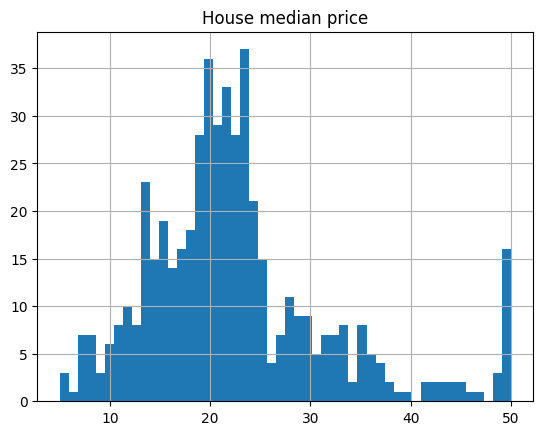

In [4]:
y.hist(bins=50)
plt.title("House median price")
plt.show();

In [5]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((354, 13), (152, 13))

## Define the model and Hyperparameter Space

In [6]:
# setup the model

gbm = GradientBoostingRegressor(random_state=0)

In [12]:
# hyperparam space

param_grid = {
    "n_estimators": (10, 120),
    "min_samples_split": (0.001, 0.99, "log-uniform"),
    "max_depth": (1, 8),
    'loss': ['squared_error', 'absolute_error', 'huber'],
}

## Bayesian Optimization

The rest of the notebook is very similar to that of RandomizedSearchCV, because the BayesSearchCV makes sure to bring forward all of Scikit-learn functionality.

In [13]:
# setting up the bayesina search like Grid Search CV

search = BayesSearchCV(
    estimator=gbm,
    search_spaces=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_iter=50,
    random_state=10,
    n_jobs=-1,
    refit=True
)

# find the best hyperparams
search.fit(X_train, y_train)

BayesSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=0),
              n_jobs=-1, random_state=10, scoring='neg_mean_squared_error',
              search_spaces={'loss': ['squared_error', 'absolute_error',
                                      'huber'],
                             'max_depth': (1, 8),
                             'min_samples_split': (0.001, 0.99, 'log-uniform'),
                             'n_estimators': (10, 120)})

In [14]:
# the best hyperparameters are stored in an attribute

search.best_params_

OrderedDict([('loss', 'huber'),
             ('max_depth', 3),
             ('min_samples_split', 0.004479086421481957),
             ('n_estimators', 120)])

In [15]:
# best score
search.best_score_

-11.092531679913812

In [16]:
# we also find the data for all models evaluated

results = pd.DataFrame(search.cv_results_)

print(results.shape)

results.head()

(50, 15)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_loss,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.058158,0.001026,0.001620,0.000059,squared_error,3,0.044228,80,"{'loss': 'squared_error', 'max_depth': 3, 'min...",-9.504739,-21.619075,-10.059739,-13.727851,5.584536,41
1,0.105515,0.003334,0.001493,0.000025,huber,2,0.308189,76,"{'loss': 'huber', 'max_depth': 2, 'min_samples...",-11.825760,-17.918399,-14.408118,-14.717426,2.496907,44
2,0.109626,0.000541,0.001700,0.000137,huber,3,0.002288,48,"{'loss': 'huber', 'max_depth': 3, 'min_samples...",-10.836626,-16.372729,-11.325955,-12.845103,2.502395,36
3,0.489709,0.012226,0.001774,0.000076,huber,5,0.001897,90,"{'loss': 'huber', 'max_depth': 5, 'min_samples...",-12.852250,-17.492956,-9.607075,-13.317427,3.236157,39
4,0.158610,0.006022,0.001599,0.000094,huber,4,0.054687,54,"{'loss': 'huber', 'max_depth': 4, 'min_samples...",-12.617916,-15.853508,-10.521013,-12.997479,2.193464,38


Text(0.5, 0, 'Hyperparameter combinations')

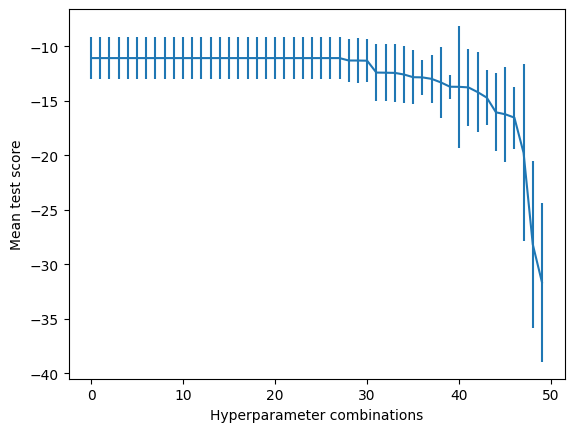

In [17]:
# we can order the different models based on their performance
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

# plot model performance and error

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean test score')
plt.xlabel('Hyperparameter combinations')

In [18]:
X_train_preds = search.predict(X_train)
X_test_preds = search.predict(X_test)

print('Train MSE: ', mean_squared_error(y_train, X_train_preds))
print('Test MSE: ', mean_squared_error(y_test, X_test_preds))

Train MSE:  1.2809368173267424
Test MSE:  16.06983814521509
